In [1]:
'''
Load the necessary libraries
'''

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

import hdbscan

import os
import glob

from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA
import numpy as np
import pandas as pd

Problematic dataset: 38

In [42]:
filename = "../pkl/id_13.fov_centroids_embedding_morphology.covd.pkl"
df = pd.read_pickle(filename)
#df = df.sample(n=100000)
embedding = df[['x','y','z']].to_numpy()

In [3]:
'''Visualize the cloud'''
fig = px.scatter_3d(df, x="x", y="y", z="z")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.write_html('nuclei-covd-embedding.html', auto_open=True)

In [43]:
'''
Calculate the local curvature of the point cloud embedding
'''
# Find the neighborood
n_neighbors = 100 # parameter to be adjausted

nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
eigvals = [LA.eigvalsh(np.cov(embedding[indices[idx,:],:].T)) for idx in range(embedding.shape[0])] #full data

curvatures = [min(eigvals[idx])/sum(eigvals[idx]) for idx in range(len(eigvals))]

# Add curvature to the dataframe
df['curvature'] = curvatures 

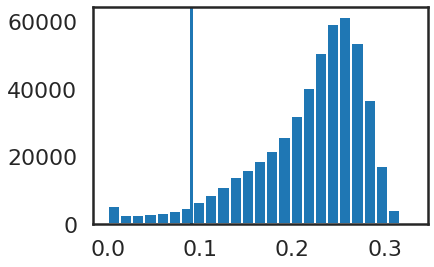

In [44]:
# Find the minima in curvature histrogram
q1 = np.quantile(curvatures,0.05)

plt.hist(curvatures,bins=25)
plt.axvline(q1,0,7500)
plt.show()

The mean intensity seems the quantity with the highest discriminative power.

In [11]:
for feature in df.columns[7:11]:
    df['color'] = pd.qcut(df[feature], 10, labels=False)
    fig = px.scatter_3d(df, x="x", y="y", z="z", color="color")
    fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
    fig.update_layout(title=feature,
                      font=dict(family="Courier New, monospace",
                                size=18,
                                color="#7f7f7f")
                         )
    fig.write_html('test.'+feature+'.3Dumap.html', auto_open=True)

In [45]:
df['color'] = pd.qcut(df['curvature'], 10, labels=False)
df1 = df[df['curvature'] <= q1] # define the low curvature sector

In [46]:
fig = px.scatter_3d(df1, x="x", y="y", z="z", color="color")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.update_layout(title='Curvature values in the first quartile',
                            font=dict(
                            family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f"
                                )
                     )
fig.write_html('test.curvature_q1.3Dumap.html', auto_open=True)

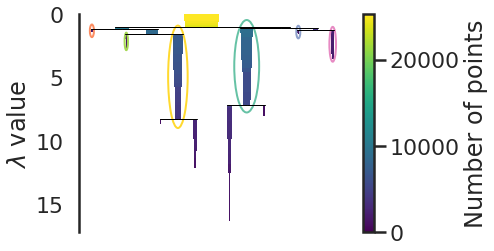

In [47]:
min_cluster_size = 1000 # parameter to be adjausted
min_samples = 100       # parameter to be adjausted
    
clusterer = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size,gen_min_span_tree=True)
clusterer.fit(df1.loc[:,('x','y','z')]) 

clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))


In [48]:
df1['cluster'] = clusterer.labels_    # add cluster id to dataframe
df1['cluster'] = df1['cluster'].apply(str)   # make cluster id a string
df_filtered = df1[df1.cluster != str(-1)] # remove unassigned points

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
    
fig = px.scatter(df_filtered, x="cx", y="cy",color="cluster",
                     width=800, height=800,
                     color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=5,opacity=1.0))
fig.write_html('spatial_decoration.html', auto_open=True)
    
fig = px.scatter_3d(df_filtered, x="x", y="y", z="z", color="cluster", hover_name="cluster", 
                        color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=3,opacity=0.75),selector=dict(mode='markers'))
fig.write_html('low_curvature_clusters.html', auto_open=True)

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,fov_row,fov_col,cx,cy,x,y,z,area,perimeter,solidity,eccentricity,mean_intensity,curvature,color,cluster
69180,43,19,9768.392954,22024.065041,4.183144,-6.215256,-3.623327,369.0,89.734019,0.832957,0.660798,20.867209,0.046224,0,1
263006,10,12,6572.714286,5307.904762,-7.083728,-5.274972,4.357306,21.0,18.863961,0.750000,0.943973,5.523810,0.027410,0,0
387224,5,30,15443.136364,2932.000000,-6.343435,-5.956690,6.910412,22.0,14.485281,1.000000,0.449119,5.090909,0.006846,0,0
388163,15,2,1509.691257,7915.147541,-4.339777,-1.472534,-5.385321,366.0,96.911688,0.800875,0.625654,5.437158,0.037699,0,0
143521,41,4,2397.957143,21416.457143,3.940596,-6.578357,-8.536629,350.0,97.083261,0.799087,0.822819,23.080000,0.044669,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27817,6,27,14034.818182,3320.772727,-6.352909,-5.941810,6.770332,44.0,22.071068,0.880000,0.377260,4.500000,0.016194,0,0
134550,11,28,14775.641509,6135.547170,-5.660924,-6.223254,7.847642,53.0,23.899495,0.981481,0.430562,4.113208,0.005690,0,0
417188,4,21,10896.220000,2528.000000,-7.029769,-5.296557,4.175116,50.0,24.142136,0.961538,0.267885,6.040000,0.049914,0,0
100861,24,10,5437.177273,12551.268182,-3.359642,-0.406319,-6.189332,220.0,80.497475,0.721311,0.853243,6.800000,0.036913,0,0


Thinking of the pipeline as a tool we should aim at simplifying the visualization and adjusting the parameters in order for the user to tune the output to his need. 

In [49]:
'''For all point cloud, find the closest cluster 
in order to label all the point and not only the low-curvature sector'''
from sklearn.metrics import pairwise_distances_argmin_min
idx, dist = pairwise_distances_argmin_min(df[['x','y','z']].to_numpy(),df_filtered[['x','y','z']].to_numpy())

In [55]:
df['cluster'] = [int(df_filtered.cluster.iloc[idx[row]])+1 for row in range(df.shape[0])] #add 1 to avoid confusion with background

In [56]:
df.to_csv(filename+'.csv',index=False)

In [57]:
print(idx.shape,df.shape)

(504854,) (504854, 15)
